# Notes on Computing the Rollout Acquisition Function
## Considerations
- Incorporate control variates for variance reduction on rollout acquisition function
- Give further consideration for the construction of arbitrary kernels and maintaining which hyperparameters belong to which kernels. I think we can borrow from the `Multi-Fidelity Bayesian Optimization` repository. I need to treat scaling of kernels as creating a kernel object with a single hyperparameter and multiply this `ScaleKernel` against the other kernel.

In [1]:
using Distributions
using LinearAlgebra
using Plots
using Roots

All the necessary imports for our computations of interest

In [2]:
include("../rollout_bayesian_optimization.jl")

to (generic function with 1 method)

## Basic Setup

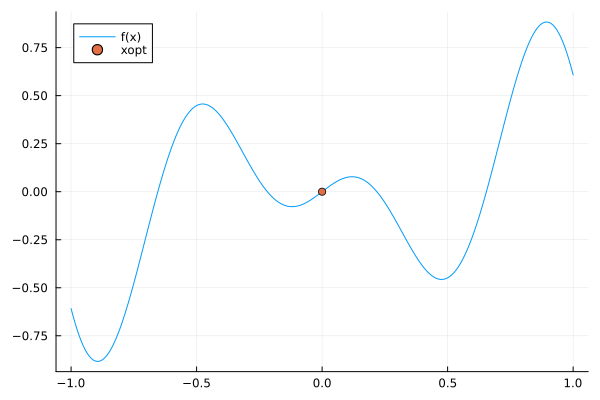

In [3]:
# Visualize 1D test function
testfn = TestLinearCosine1D(1., 7.2, lb=-1, ub=1.)
# testfn = TestGramacyLee()
domain = dense_1D_discretization(lb=testfn.bounds[1,1], ub=testfn.bounds[1,2], stepsize=.01)
testfn = vshift(testfn, -sum(testfn([x]) for x in domain) / length(domain))
# testfn = TestConstant(lbs=[0.], ubs=[1.])
tplot(testfn)

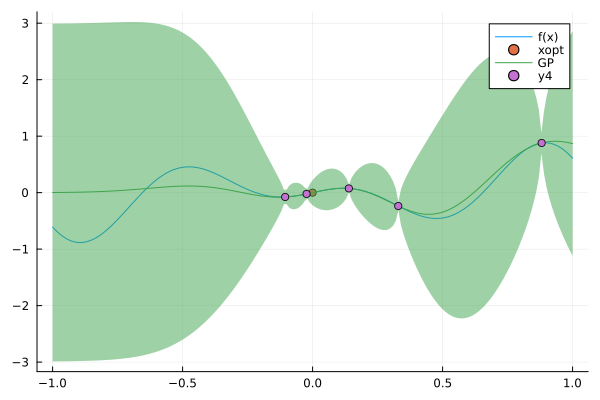

In [10]:
MC_SAMPLES = 500
NUMBER_OF_STARTS = 32
HORIZON = 1
USE_LDS = true
INITIAL_SAMPLES = 5

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
# ψ = kernel_matern52(θ)
# ψ = kernel_scale(kernel_matern52, [5., .25])
ψ = kernel_scale(kernel_SE, [5., .25])

lbs, ubs = get_bounds(testfn)
domain = dense_1D_discretization(lb=first(lbs), ub=first(ubs), stepsize=.01)

# Allocate initial guesses for optimizer
θinit = [.1]
θlbs, θubs = [-1.], [1.]
xstarts = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)
θstarts = generate_initial_guesses(NUMBER_OF_STARTS, θlbs, θubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    start=xstarts[:, 1],
    horizon=HORIZON,
    mc_iterations=MC_SAMPLES,
    use_low_discrepancy_sequence=USE_LDS,
    spatial_lowerbounds=lbs,
    spatial_upperbounds=ubs,
    hyperparameters_lowerbounds=θlbs,
    hyperparameters_upperbounds=θubs,
    hypers=θinit
)

Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
# Xinit = [.15;; .85;;]
yinit = testfn(Xinit)

sur = Surrogate(ψ, Xinit, yinit, base_policy=EI(), σn2=σn2);
tplot(testfn)
plot!(domain, [sur([x], θinit).μ for x in domain], ribbons=2sqrt.([sur([x], θinit).σ for x in domain]), label="GP")
scatter!(sur.X', sur.y)

## On Perturbing the jth Policy Solve

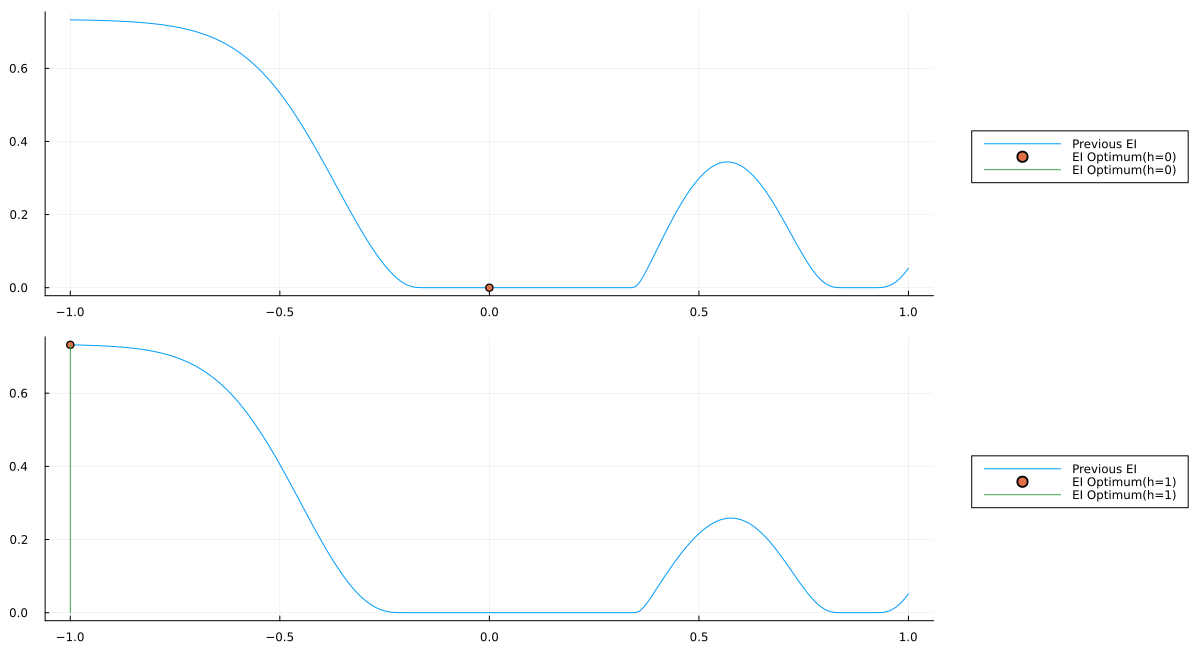

In [11]:
IS_DETERMINISTIC = true
# Construct the inner policy
base_policy = EI()
lbs, ubs = get_spatial_bounds(tp)

# Construct GP
flex_sur = Surrogate(ψ, Xinit, yinit, base_policy=base_policy, σn2=σn2)

# Construct trajectory
AT = AdjointTrajectory(
    base_surrogate=flex_sur,
    start=get_starting_point(tp),
    hypers=get_hyperparameters(tp),
    horizon=get_horizon(tp)
)
stochastic_sampler = StochasticObservable(
    surrogate=get_fantasy_surrogate(AT), stdnormal=get_samples_rnstream(tp, sample_index=1), max_invocations=get_horizon(tp) + 1
)
deterministic_sampler = DeterministicObservable(
    func=testfn.f, gradient=testfn.∇f, max_invocations=HORIZON + 1
)
attach_observable!(AT, IS_DETERMINISTIC ? deterministic_sampler : stochastic_sampler)

# Adjoint Rollout
adjoint_rollout!(
    AT,
    spatial_lbs=lbs,
    spatial_ubs=ubs,
    hyperparameters_lbs=θlbs,
    hyperparameters_ubs=θubs,
    xstarts=xstarts,
    θstarts=θstarts,
    get_observation=get_observable(AT)
)

all_plots = []

for upto_index in 0:HORIZON
    EIx = zeros(length(domain))
    for (i, xx) in enumerate(domain)
        EIx[i] = eval(AT.fs([xx], θinit, fantasy_index=upto_index-1))
    end
    p = plot(domain, EIx, label="Previous EI")
    target_location = first(AT.fs.X[:, INITIAL_SAMPLES + upto_index + 1])
    
    scatter!(
        [target_location],
        [eval(AT.fs([target_location], θinit, fantasy_index=upto_index-1))],
        label="EI Optimum(h=$upto_index)"
    )
    
    plot!(
        [target_location, target_location],
        [0., eval(AT.fs([target_location], θinit, fantasy_index=upto_index-1))],
        label="EI Optimum(h=$upto_index)"
    )
    push!(all_plots, p)
end

plot(all_plots..., layout=(length(all_plots), 1), size=(1200, 325 * (HORIZON + 1)), legend=:outerright)

In [12]:
resolutions = zeros(MC_SAMPLES)
gresolutions = zeros(testfn.dim, MC_SAMPLES)
θresolutions = zeros(length(get_hyperparameters(tp)), MC_SAMPLES)

etos = []

for (index, xx) in enumerate(domain)
    print("|")
    set_starting_point!(tp, [xx])
    # Adjoint mode
    if IS_DETERMINISTIC
        eto = deterministic_simulate_trajectory(
            sur,
            tp,
            inner_solve_xstarts=xstarts,
            inner_solve_θstarts=θstarts,
            func=testfn.f,
            grad=testfn.∇f
        )
    else
        eto = simulate_adjoint_trajectory(
            sur,
            tp,
            inner_solve_xstarts=xstarts,
            inner_solve_θstarts=θstarts,
            resolutions=resolutions,
            spatial_gradients_container=gresolutions,
            hyperparameter_gradients_container=θresolutions
        )
    end
    push!(etos, eto)
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

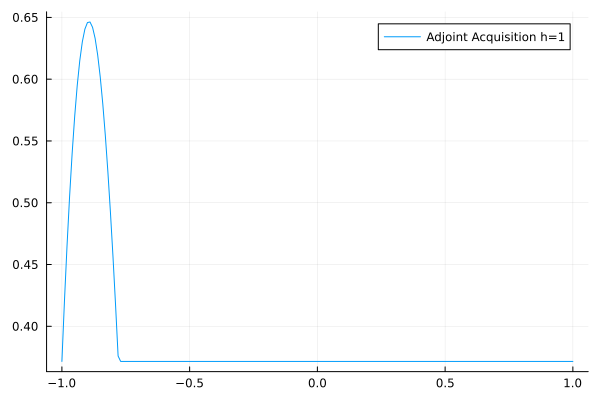

In [13]:
plot(
    domain,
    [mean(eto) for eto in etos],
    ribbons=[std(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition h=$(get_horizon(tp))"
)

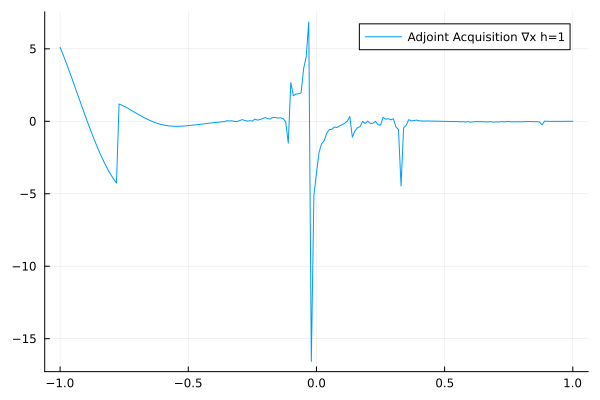

In [14]:
plot(
    domain,
    [(first ∘ gradient)(eto) for eto in etos],
    ribbons=[(first ∘ std_gradient)(eto) / sqrt(MC_SAMPLES) for eto in etos],
    label="Adjoint Acquisition ∇x h=$(get_horizon(tp))"
)

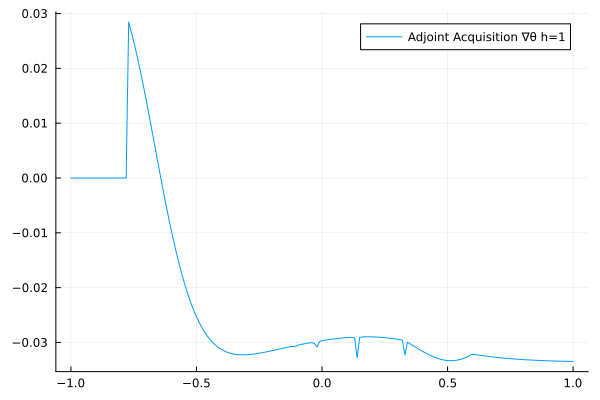

In [15]:
plot(
    domain,
    [first(gradient(eto, wrt_hypers=true)) for eto in etos],
    ribbons=[
        first(std_gradient(eto, wrt_hypers=true)) / sqrt(MC_SAMPLES)
        for eto in etos
    ],
    label="Adjoint Acquisition ∇θ h=$(get_horizon(tp))",
)